In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, roc_curve, classification_report
from imblearn.over_sampling import SMOTE
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt

In [51]:
df_fraud = pd.read_csv("Fraud_Data.csv")
df_ip = pd.read_table("IpAddress_to_Country.txt", delimiter=",")

df_fraud.head()

## show column types
# df_fraud.describe()

## show stat distribution
# df_fraud.info()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [52]:
df_ip.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [53]:
def ip_to_country(x):
    ip =  x["ip_address"]
    matched = df_ip[(df_ip['lower_bound_ip_address'] <= ip) & (ip <= df_ip["upper_bound_ip_address"])]
    if len(matched) == 1:
        return matched["country"].values[0]
    else:
        return "NA"

df_fraud["country"] = df_fraud.apply(lambda x: ip_to_country(x), axis=1)

In [54]:
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States


In [55]:
df_fraud["purchase_time"] = pd.to_datetime(df_fraud["purchase_time"])
df_fraud["signup_time"] = pd.to_datetime(df_fraud["signup_time"])

In [56]:
df_fraud["time_diff"] = df_fraud.apply(lambda x: (x["purchase_time"] - x["signup_time"]).seconds, axis=1)

# Signup day and week
df_fraud['signup_day'] = df_fraud['signup_time'].apply(lambda x: x.dayofweek)
df_fraud['purchase_day'] = df_fraud['purchase_time'].apply(lambda x: x.dayofweek)


In [58]:
# Check user number for unique devices
device_num = df_fraud[['user_id', 'device_id']].groupby('device_id').count().reset_index()
device_num = device_num.rename(columns={'user_id': 'device_num'})
df_fraud = df_fraud.merge(device_num, how='left', on='device_id')

# Check user number for unique ip_address
ip_num = df_fraud[['user_id', 'ip_address']].groupby('ip_address').count().reset_index()
ip_num = ip_num.rename(columns={'user_id': 'ip_num'})
df_fraud = df_fraud.merge(ip_num, how='left', on='ip_address')

In [59]:
df_fraud.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,time_diff,signup_day,purchase_day,device_num,ip_num
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,13882,1,5,1,1
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944,6,0,1,1
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1,3,3,12,12
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,NA,60085,1,0,1,1
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,41461,1,2,1,1


In [60]:
numeric_cols = ['purchase_value','age','time_diff','signup_day','purchase_day','ip_num','device_num']
category_cols = ['source','browser','sex', 'country']
label_cols = ['class']

# encode categorical labels
# encoded_cols = []
# for col in ['browser','sex', 'country']:
#     le = preprocessing.LabelEncoder()
#     df_fraud[f"{col}_encoded"] = le.fit_transform(df_fraud[col])
#     encoded_cols.append(f"{col}_encoded")

for col in category_cols:
    df_fraud[col] = pd.Series(df_fraud[col], dtype="category")

X = df_fraud[numeric_cols + category_cols]
y = df_fraud[label_cols]

In [64]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151112 entries, 0 to 151111
Data columns (total 17 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   user_id         151112 non-null  int64         
 1   signup_time     151112 non-null  datetime64[ns]
 2   purchase_time   151112 non-null  datetime64[ns]
 3   purchase_value  151112 non-null  int64         
 4   device_id       151112 non-null  object        
 5   source          151112 non-null  category      
 6   browser         151112 non-null  category      
 7   sex             151112 non-null  category      
 8   age             151112 non-null  int64         
 9   ip_address      151112 non-null  float64       
 10  class           151112 non-null  int64         
 11  country         151112 non-null  category      
 12  time_diff       151112 non-null  int64         
 13  signup_day      151112 non-null  int64         
 14  purchase_day    151112 non-null  int

In [61]:
# split train, validation, test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2022)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=2022)

In [62]:
for data,label in zip((X_train, X_val, X_test), (y_train, y_val, y_test)):
    print(data.shape, label.shape)

(74044, 11) (74044, 1)
(31734, 11) (31734, 1)
(45334, 11) (45334, 1)


In [170]:
 # training

# train_data = lgb.Dataset(X_train, label=y_train)
# valid_data = lgb.Dataset(X_val, label=y_val)


hyper_params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': ['l2','auc'],
    "num_leaves": 128,  
    "max_bin": 512,
    'class_weight':'balanced',
    'colsample_bytree':0.6
}

clf = lgb.LGBMClassifier(**hyper_params)



In [171]:
clf.fit(X_train, y_train,verbose=True)

/Users/jinyijia/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jinyijia/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jinyijia/Library/Python/3.8/lib/python/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


LGBMClassifier(class_weight='balanced', colsample_bytree=0.6, max_bin=512,
               metric=['l2', 'auc'], num_leaves=128, objective='binary')

In [172]:
# prediction
y_pred_train = clf.predict_proba(X_train)
y_pred_test = clf.predict_proba(X_test)


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

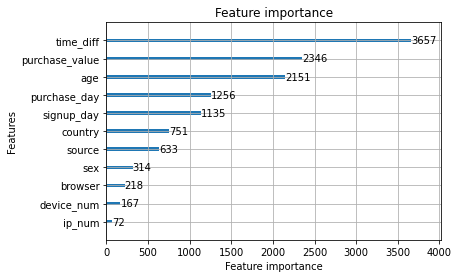

In [173]:
lgb.plot_importance(clf)


In [180]:
# performance, no class weight
train_true = np.array(y_train['class'])
test_true = np.array(y_test['class'])
train_pred = np.array(y_pred_train[:,1]) #[class_0, class_1]
test_pred =np.array(y_pred_test[:,1])

print(clf, ", no resampling")
print("------------------")
print(classification_report(y_true=test_true, y_pred=(test_pred>0.5)))

LGBMClassifier(class_weight='balanced', colsample_bytree=0.6, max_bin=512,
               metric=['l2', 'auc'], num_leaves=128, objective='binary') , no resampling
------------------
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     41086
           1       0.60      0.68      0.64      4248

    accuracy                           0.93     45334
   macro avg       0.78      0.82      0.80     45334
weighted avg       0.93      0.93      0.93     45334



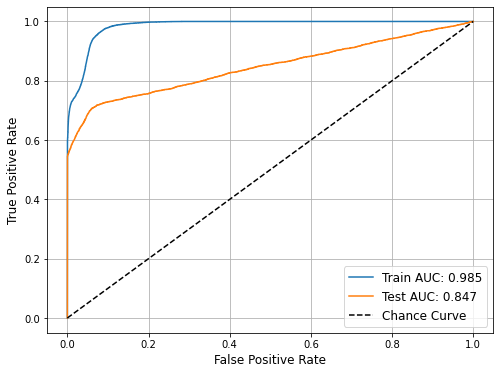

In [181]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)


train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()

**with resampling**

In [168]:
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import RandomOverSampler

# handle class imbalance

X_resampled, y_resampled = RandomOverSampler().fit_resample(X_train, y_train)
y_train.value_counts(), y_resampled.value_counts()

# train
clf = lgb.LGBMClassifier(**hyper_params)
clf.fit(X_resampled, y_resampled)
# prediction
y_pred_train_resample = clf.predict(X_resampled)
y_pred_test = clf.predict(X_test)

# performance, SMOTE resampling
train_true = np.array(y_resampled['class'])
test_true = np.array(y_test['class'])
train_pred = np.array(y_pred_train_resample) #[class_0, class_1]
test_pred =np.array(y_pred_test)

print(clf, ", SMOTE resampling")
print("------------------")
print(classification_report(y_true=test_true, y_pred=test_pred))

/Users/jinyijia/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/jinyijia/Library/Python/3.8/lib/python/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LGBMClassifier(class_weight='balanced', colsample_bytree=0.6, max_bin=512,
               metric=['l2', 'auc'], num_leaves=128, objective='binary') , SMOTE resampling
------------------
              precision    recall  f1-score   support

           0       0.97      0.96      0.96     41086
           1       0.62      0.67      0.64      4248

    accuracy                           0.93     45334
   macro avg       0.79      0.81      0.80     45334
weighted avg       0.93      0.93      0.93     45334



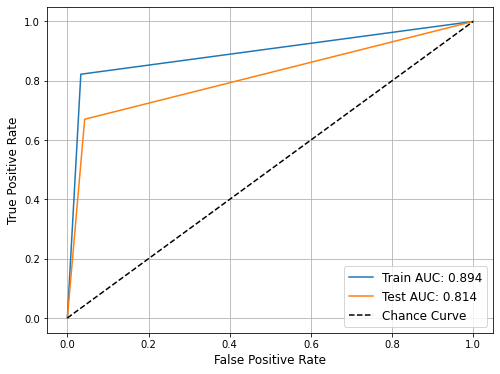

In [169]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
train_auc = np.round(auc(train_fpr, train_tpr), 3)
test_auc = np.round(auc(test_fpr, test_tpr), 3)


train_fpr = np.insert(train_fpr, 0, 0)
train_tpr = np.insert(train_tpr, 0, 0)
test_fpr = np.insert(test_fpr, 0, 0)
test_tpr = np.insert(test_tpr, 0, 0)

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(train_fpr, train_tpr, label='Train AUC: ' + str(train_auc))
ax.plot(test_fpr, test_tpr, label='Test AUC: ' + str(test_auc))
ax.plot(train_fpr, train_fpr, 'k--', label='Chance Curve')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.grid(True)
ax.legend(fontsize=12)
plt.show()